# 1 Generate Training Set:
- Generate a training set of time series x_2(t) by numerically solving the Lorenz system equations (Equation 4), using parameters σ=10, r=28, and b=8/3.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [122]:
class LorenzDataCreator:
    def __init__(self, sigma, r, b, initial_conditions, timestep, total_steps, skip_steps):
        self.sigma = sigma
        self.r = r
        self.b = b
        self.x1, self.x2, self.x3 = initial_conditions
        self.timestep = timestep
        self.total_steps = total_steps
        self.skip_steps = skip_steps

    def lorenz_dx1(self, x1, x2):
        return -self.sigma * x1 + self.sigma * x2

    def lorenz_dx2(self, x1, x2, x3):
        return -x1 * x3 + self.r * x1 - x2

    def lorenz_dx3(self, x1, x2, x3):
        return x1 * x2 - self.b * x3

    def simulate(self):
        solution = np.zeros((self.total_steps, 3))
        time_points = np.zeros(self.total_steps)

        for t in range(self.skip_steps):
            self.x1 += self.timestep * self.lorenz_dx1(self.x1, self.x2)
            self.x2 += self.timestep * self.lorenz_dx2(self.x1, self.x2, self.x3)
            self.x3 += self.timestep * self.lorenz_dx3(self.x1, self.x2, self.x3)

        solution[0, :] = [self.x1, self.x2, self.x3]

        for t in range(1, self.total_steps):
            time_points[t] = time_points[t-1] + self.timestep
            self.x1 += self.timestep * self.lorenz_dx1(self.x1, self.x2)
            self.x2 += self.timestep * self.lorenz_dx2(self.x1, self.x2, self.x3)
            self.x3 += self.timestep * self.lorenz_dx3(self.x1, self.x2, self.x3)

            solution[t, :] = [self.x1, self.x2, self.x3]

        return time_points, solution

    def save_data(self, time_points, solution):
        split_index = int(0.8 * self.total_steps)

        train_part = solution[:split_index, :]
        test_part = solution[split_index:, :]

        train_time = time_points[:split_index]
        test_time = time_points[split_index:]

        pd.DataFrame(train_time).to_csv('training-times.csv', index=False, header=False)
        pd.DataFrame(test_time).to_csv('test-times.csv', index=False, header=False)

        pd.DataFrame(train_part.T).to_csv('training-set.csv', index=False, header=False)
        pd.DataFrame(test_part.T).to_csv('test-set.csv', index=False, header=False)

# Create an instance of the class
generator = LorenzDataCreator(10, 28, 8/3, [1, 1, 1], 0.02, 10000, 500)
time_points, solution = generator.simulate()
generator.save_data(time_points, solution)


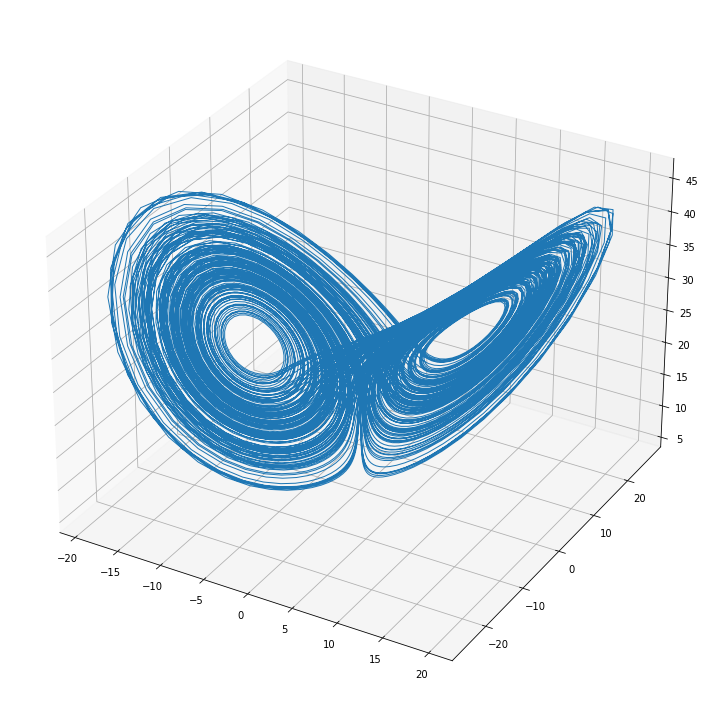

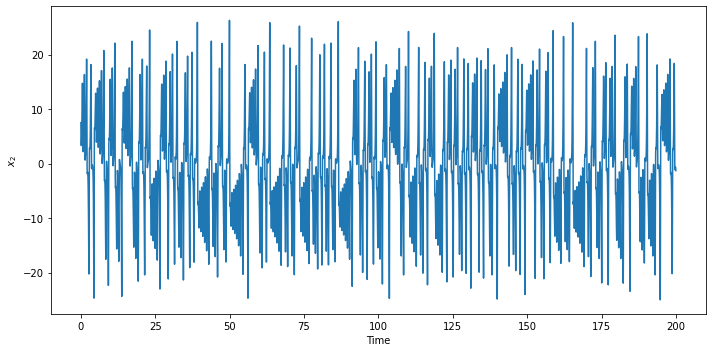

In [123]:
import matplotlib.pyplot as plt

def plot_data(time_points, solution):
    plt.rcParams["figure.figsize"] = [10, 10]
    plt.rcParams["figure.autolayout"] = True
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(solution[:, 0], solution[:, 1], solution[:, 2], linewidth=1)
    plt.show()


    plt.rcParams["figure.figsize"] = [10, 5]
    plt.figure()
    plt.plot(time_points, solution[:, 1])
    plt.xlabel('Time')
    plt.ylabel(f'$x_{2}$')
    plt.show()

plot_data(time_points, solution)


# 2 Set Up and Train Reservoir:
- Set up a reservoir as described in Equation 1 and train the output weights to minimize the energy function when predic the Lorenz system.

In [359]:
class ReservoirComputer:
    def __init__(self, training_data, evaluation_data, dimensions, regularization_factor, variance_input, variance_reservoir):
        self.input_size = dimensions[0]
        self.reservoir_size = dimensions[1]
        self.output_size = dimensions[2]
        self.prediction_length = 500
        self.regularization = regularization_factor

        # Initialize weights from a normal distribution based on specified variances

        
        #self.weights_input = np.random.uniform(-0.1, 0.1, size=(self.reservoir_size, self.input_size))
        #self.weights_reservoir = np.random.uniform(0, 1, size=(self.reservoir_size, self.reservoir_size))
        #self.radius = np.linalg.svd(self.weights_reservoir, compute_uv=False)[0]
        #self.weights_reservoir = (self.weights_reservoir / self.radius) * variance_reservoir
        
        self.weights_input = np.random.normal(0, variance_input, size=(self.reservoir_size, self.input_size))
        self.weights_reservoir = np.random.normal(0, variance_reservoir, size=(self.reservoir_size, self.reservoir_size))
        
        # Output weights initialization, will be trained later
        self.weights_output = np.random.uniform(-0.1, 0.1, size=(self.reservoir_size, self.output_size))

        self.training_data = training_data
        self.testing_data = evaluation_data

    def update_state(self, input_vector, current_state):
        # Update the reservoir's state using the hyperbolic tangent activation function
        return np.tanh(np.dot(self.weights_reservoir, current_state) + np.dot(self.weights_input, input_vector))

    def train_output_weights(self, target, state_matrix):
        # Train output weights using ridge regression
        state_transpose = np.transpose(state_matrix)
        identity_matrix = self.regularization * np.ones(np.shape(np.matmul(state_matrix, state_transpose)))
        return np.matmul(target, np.matmul(state_transpose, np.linalg.inv(np.add(np.matmul(state_matrix, state_transpose), identity_matrix))))
    
    def calculate_divergence_time(self, predicted, actual, tolerance=10, max_lambda=0.93652738, delta_t=0.02):
        
        if predicted.ndim > 1 and predicted.shape[0] > 1:
            differences = np.abs(predicted[1] - actual[1])
        else:
            differences = np.abs(predicted[0] - actual[0])

        # Process each difference and check against the tolerance
        for index, diff in enumerate(differences):
                if diff > tolerance:
                    return index * max_lambda * delta_t

        return index * max_lambda * delta_t

    def calculate_output(self, state):
        # Compute output from current state
        return np.dot(self.weights_output, state)

    def train(self):
        total_time_steps = np.shape(self.training_data)[-1]

        # Initialize state as zero
        reservoir_state = np.zeros(self.reservoir_size)

        # Collect all states for training
        collected_states = np.zeros((self.reservoir_size, total_time_steps))

        for t in range(total_time_steps):
            current_input = self.training_data[:, t]
            collected_states[:, t] = reservoir_state
            reservoir_state = self.update_state(current_input, reservoir_state)

        self.weights_output = self.train_output_weights(self.training_data, collected_states)

    def predict(self):
        prediction_start = int(np.shape(self.testing_data)[-1] - self.prediction_length)
        initial_testing_data = self.testing_data[:, :prediction_start]
        testing_times = np.shape(initial_testing_data)[-1]

        # Start with zero state
        current_state = np.zeros(self.reservoir_size)
        states_during_test = np.zeros((self.reservoir_size, testing_times))

        for t in range(testing_times - 1):
            next_input = self.testing_data[:, t + 1]
            states_during_test[:, t] = current_state
            current_state = self.update_state(next_input, current_state)

        # Use the last state to start predictions
        last_output = self.calculate_output(current_state)
        predictions = np.zeros((self.output_size, self.prediction_length))
        new_state = np.copy(current_state)

        for i in range(self.prediction_length):
            new_state = self.update_state(last_output, new_state)
            last_output = self.calculate_output(new_state)
            new_state = np.copy(new_state)
            predictions[:, i] = last_output

        divergence_time = self.calculate_divergence_time(predictions, self.testing_data[:, prediction_start:])

        return predictions, self.testing_data[:, prediction_start:], divergence_time

    def execute(self):
        # Execute training and then prediction
        self.train()
        predictions, validation_data, error_metric = self.predict()

        return np.transpose(error_metric), np.transpose(predictions), np.transpose(validation_data)



# 3 Train Two Reservoirs:
- Train two reservoirs, one on the entire Lorenz system and another only on the x_2 variable. Evaluate their prediction performance over a range of different values for the maximal singular value of the reservoir weight matrix 𝑊 Approximate the upper and lower bounds of singular values that allow the reservoir to predict the time series effectively. Discuss the observed differences.

In [190]:
train_data_all = pd.read_csv('training-set.csv', header=None).to_numpy()
test_data_all = pd.read_csv('test-set.csv', header=None).to_numpy()

train_data_x2 = np.zeros((1, len(train_data_all[1, :])))
test_data_x2 = np.zeros((1, len(test_data_all[1, :])))

train_data_x2[:] = train_data_all[1, :]
test_data_x2[:] = test_data_all[1, :]


#### x_2 reservoir

In [309]:
rc_model_x2 = ReservoirComputer(train_data_x2, test_data_x2, [1, 500, 1], 0.1,  0.02, 0.05)
loss_x2, pred_x2, val_x2 = rc_model_x2.execute()

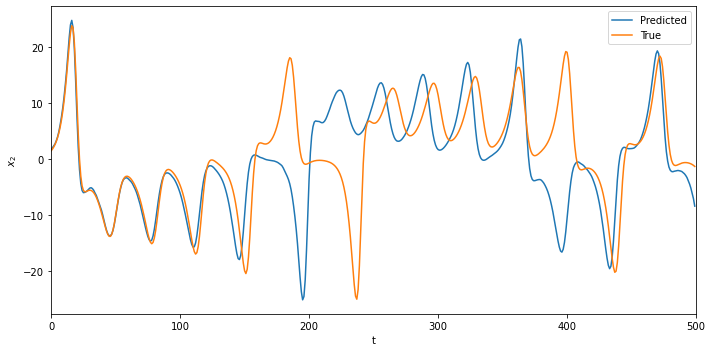

In [310]:
plt.figure()
plt.plot(np.arange(0, len(pred_x2)), pred_x2)
plt.plot(np.arange(0, len(val_x2)), val_x2)

plt.legend(['Predicted', 'True'])
plt.xlabel('t')
plt.ylabel(rf'$x_2$')
plt.xlim(0, len(pred_x2))
plt.show()

#### Full reservoir

In [311]:
rc_model_full = ReservoirComputer(train_data_all, test_data_all, [3, 500, 3], 0.1,  0.02, 0.05)
loss_full, pred_full, val_full = rc_model_full.execute()

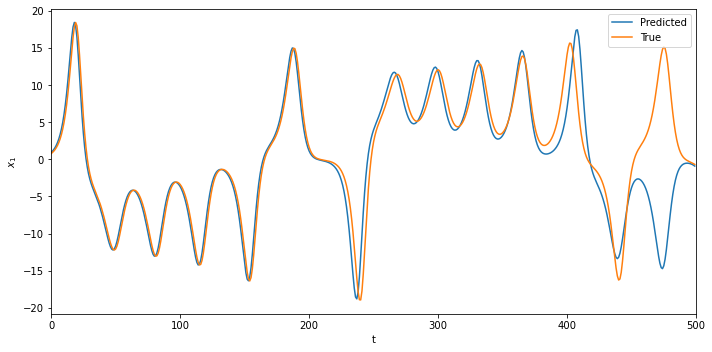

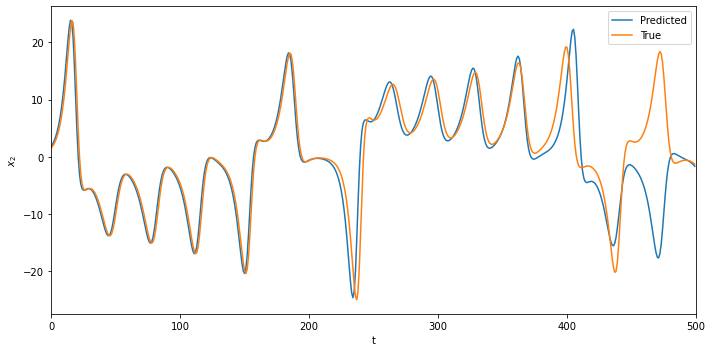

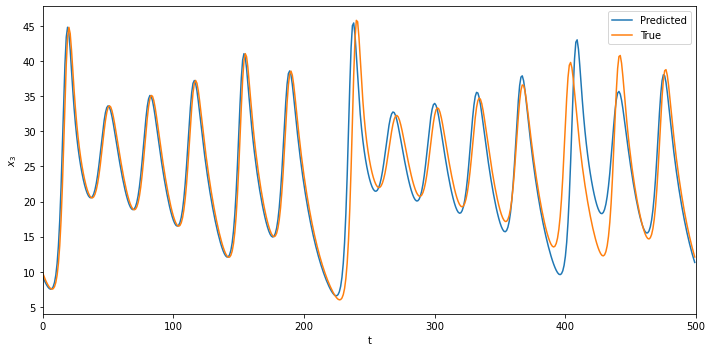

In [312]:
for i in range(3):
    plt.figure()
    plt.plot(np.arange(0, len(pred_full[:, i])), pred_full[:, i])
    plt.plot(np.arange(0, len(val_full[:, i])), val_full[:, i])

    plt.legend(['Predicted', 'True'])
    plt.xlabel('t')
    plt.ylabel(rf'$x_{i+1}$')
    plt.xlim(0, len(pred_full))
    plt.show()

#### Predict maximal singular value of the reservoir weight matrix 𝑊

In [ ]:
in_var = 0.02
res_vars = np.linspace(1e-2, 1e2, num=50)/500

n_reals = 10
losses = np.zeros((2, n_reals, len(res_vars)))
singulars = np.zeros((2, n_reals, len(res_vars)))

for n in range(n_reals):
    #print(f'\nRealisation nr. {n + 1}/{n_reals}...\n')
    for i, res_var in enumerate(res_vars):
        #print(f'Current input variance value: {in_var:.06f}, current reservoir variance: {res_var:.06f}')
        res1 = ReservoirComputer(train_data_all, test_data_all, [3, 500, 3], 0.1, in_var, res_var)
        res2 = ReservoirComputer(train_data_x2, test_data_x2, [1, 500, 1], 0.1, in_var, res_var)

        loss1, pred1, val1 = res1.execute()
        loss2, pred2, val2 = res2.execute()

        losses[0, n, i] = loss1
        losses[1, n, i] = loss2

        singulars[0, n, i] = np.linalg.svd(res1.weights_reservoir, compute_uv=False)[0]
        singulars[1, n, i] = np.linalg.svd(res2.weights_reservoir, compute_uv=False)[0]


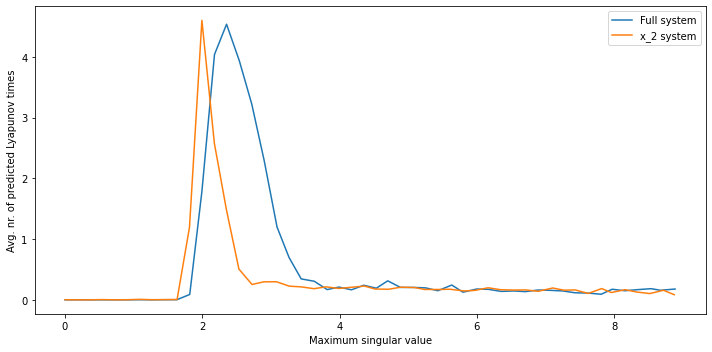

In [368]:
loss = np.mean(losses, axis=1)
singular = np.mean(singulars, axis=1)
plt.figure()
plt.plot(singular[0], loss[0, :])
plt.plot(singular[1], loss[1, :])
plt.xlabel(r'Maximum singular value')

plt.ylabel('Avg. nr. of predicted Lyapunov times')
plt.legend(['Full system', 'x_2 system'])
plt.show()


# 4 Evaluate Prediction Performance:
- Determine the maximal Lyapunov exponent 𝜆_1 by numerical simulation of the Lorenz system (Equation 4). Evaluate how well the reservoir computer predicts the 𝑥_2(𝑡) time series and compare this with standard methods. Plot the prediction error as a function of 𝑡𝜆_1.

#### Find maximal Lypaunov exponent

In [ ]:
# Create an instance of the data generator with specified parameters
lorenz_generator = LorenzDataCreator(10, 28, 8/3, [1, 1, 1], 0.001, 1_000_000, 50_00)
time_points, lorenz_series = lorenz_generator.simulate()

# Define a function to compute the Jacobian matrix of the Lorenz system at any given point
def calculate_jacobian(x1, x2, x3, sigma=10, r=28, b=8/3):
    """Calculate the Jacobian matrix for the Lorenz system at a given state."""
    return np.array([[-sigma, sigma, 0], [r - x3, -1, -x1], [x2, x1, -b]])

# Initialize matrices for QR decomposition method
identity_matrix = np.eye(3)
orthogonal_matrix = np.eye(3)
lyapunov_exponents = np.zeros(3)

# Loop through each time point to update the QR decomposition
for index in range(len(time_points)):
    x1, x2, x3 = lorenz_series[index][0], lorenz_series[index][1], lorenz_series[index][2]

    # Compute the incremental matrix for QR update
    update_matrix = identity_matrix + calculate_jacobian(x1, x2, x3) * 0.001
    # QR decomposition of the updated matrix
    orthogonal_matrix, upper_triangular_matrix = np.linalg.qr(np.matmul(update_matrix, orthogonal_matrix))

    # Sum the logarithms of the diagonal elements of R to compute Lyapunov exponents
    lyapunov_exponents[0] += np.log(np.abs(upper_triangular_matrix[0, 0]))
    lyapunov_exponents[1] += np.log(np.abs(upper_triangular_matrix[1, 1]))
    lyapunov_exponents[2] += np.log(np.abs(upper_triangular_matrix[2, 2]))

# Normalize the sum to get the average exponent over the entire time series
lyapunov_exponents = lyapunov_exponents / (len(time_points) * 0.001)
lyapunov_max = max(lyapunov_exponents)
print(lyapunov_max)


0.9365273787999631


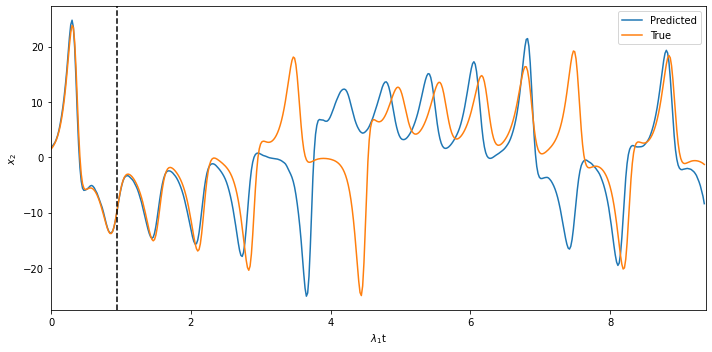

In [370]:
dt=0.02

plt.figure()
plt.plot(np.arange(0, len(pred_x2)) * dt*lyapunov_max, pred_x2)
plt.plot(np.arange(0, len(val_x2)) * dt*lyapunov_max, val_x2)

plt.axvline(x=lyapunov_max, color='k', linestyle='--')
plt.legend(['Predicted', 'True'])
plt.xlabel(r'$\lambda_1$t')
plt.ylabel(rf'$x_2$')
plt.xlim(0, len(pred_x2)* dt*lyapunov_max)
plt.show()

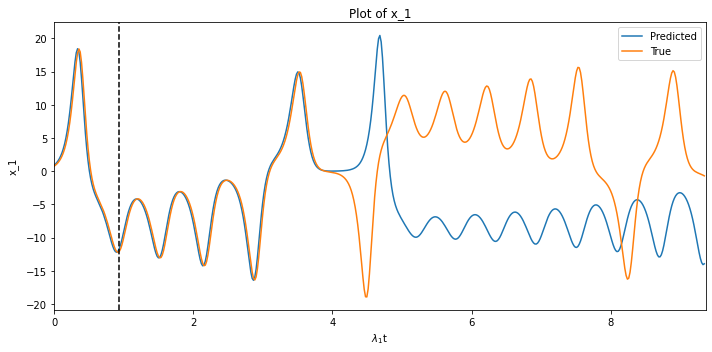

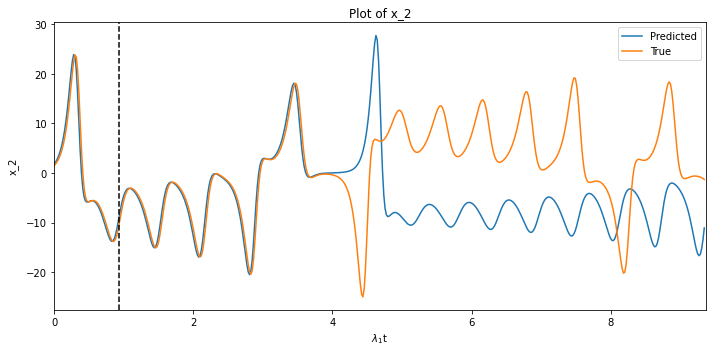

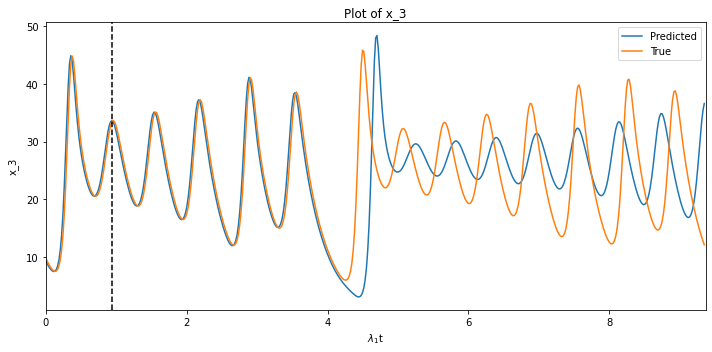

In [93]:
dt=0.02

for i in range(3):
    plt.figure()
    plt.plot(np.arange(0, len(pred_full[:, i])) * dt * lyapunov_max, pred_full[:, i], label='Predicted')
    plt.plot(np.arange(0, len(val_full[:, i])) * dt * lyapunov_max, val_full[:, i], label='True')

    plt.axvline(x=lyapunov_max, color='k', linestyle='--')
    plt.legend()
    plt.xlabel(r'$\lambda_1$t')
    plt.ylabel(rf'x_${i+1}$')
    plt.xlim(0, len(pred_full[:, i]) * dt * lyapunov_max)
    plt.title(f'Plot of x_{i+1}')
    plt.show()

####  Prediction error

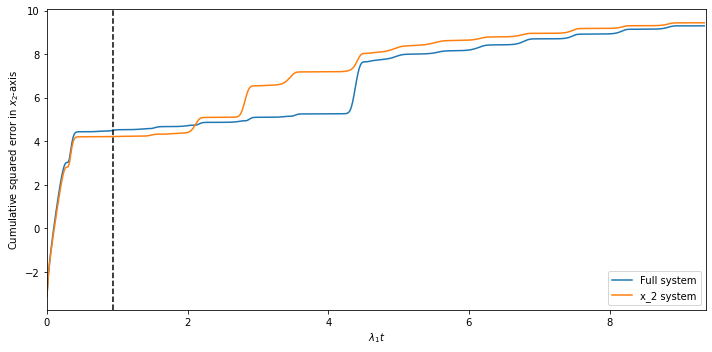

In [369]:
# Number of realizations for simulation
num_realizations = 50

predictions_full = np.zeros((num_realizations, 500))
validation_full = np.zeros((num_realizations, 500))

predictions_partial = np.zeros((num_realizations, 500))
validation_partial = np.zeros((num_realizations, 500))

for idx in range(num_realizations):
    reservoir_single = ReservoirComputer(train_data_x2, test_data_x2, [1, 500, 1], 0.1, 0.02, 0.05)
    loss_single, prediction_single, validation_single = reservoir_single.execute()

    reservoir_all = ReservoirComputer(train_data_all, test_data_all, [3, 500, 3], 0.1, 0.02, 0.05)
    loss_all, prediction_all, validation_all = reservoir_all.execute()

    # Store predictions and validations in the arrays
    predictions_full[idx, :] = prediction_all[:, 1]
    predictions_partial[idx, :] = np.transpose(prediction_single[:])

    validation_full[idx, :] = validation_all[:, 1]
    validation_partial[idx, :] = np.transpose(validation_single[:])

# Calculate mean predictions and validations across all realizations
predictions_full_mean = np.mean(predictions_full, axis=0)
predictions_partial_mean = np.mean(predictions_partial, axis=0)
validation_full_mean = np.mean(validation_full, axis=0)
validation_partial_mean = np.mean(validation_partial, axis=0)

# Function to plot prediction errors
def plot_prediction_errors(preds, vals, max_lambda=0.93652738, time_step=0.02):
    plt.figure()

    # Calculate cumulative squared prediction errors
    error_full = 0.5 * np.cumsum(np.square(preds[0] - vals[0]), axis=0)
    error_single = 0.5 * np.cumsum(np.square(preds[1] - vals[1]), axis=0)

    # Plot the logarithmic error
    plt.plot(np.arange(0, 500) * time_step * max_lambda, np.log(error_full))
    plt.plot(np.arange(0, 500) * time_step * max_lambda, np.log(error_single))

    plt.axvline(x=lyapunov_max, color='k', linestyle='--')
    plt.xlabel(r'$\lambda_1t$')
    plt.ylabel('Cumulative squared error in $x_2$-axis')
    plt.xlim(0, 500 * time_step * max_lambda)
    plt.legend(['Full system', 'x_2 system'])
    plt.show()

plot_prediction_errors(np.array([predictions_full_mean, predictions_partial_mean]), 
                       np.array([validation_full_mean, validation_partial_mean]))
